__Structural Estimation__ <br>
Problem Set 3 <br>
February 6, 2019 <br>
Ginha Kim <br>

In [2]:
# Import libraries
import numpy as np
import scipy.stats as sts
import pandas as pd
from pandas import DataFrame, Series
import scipy.integrate as integ
import scipy.optimize as opt
from scipy.stats import gamma
import scipy.special as spc
import matplotlib.pyplot as plt
%matplotlib notebook

## Problem 1
Matching the U.S. income distribution by GMM

## (a)

<IPython.core.display.Javascript object>


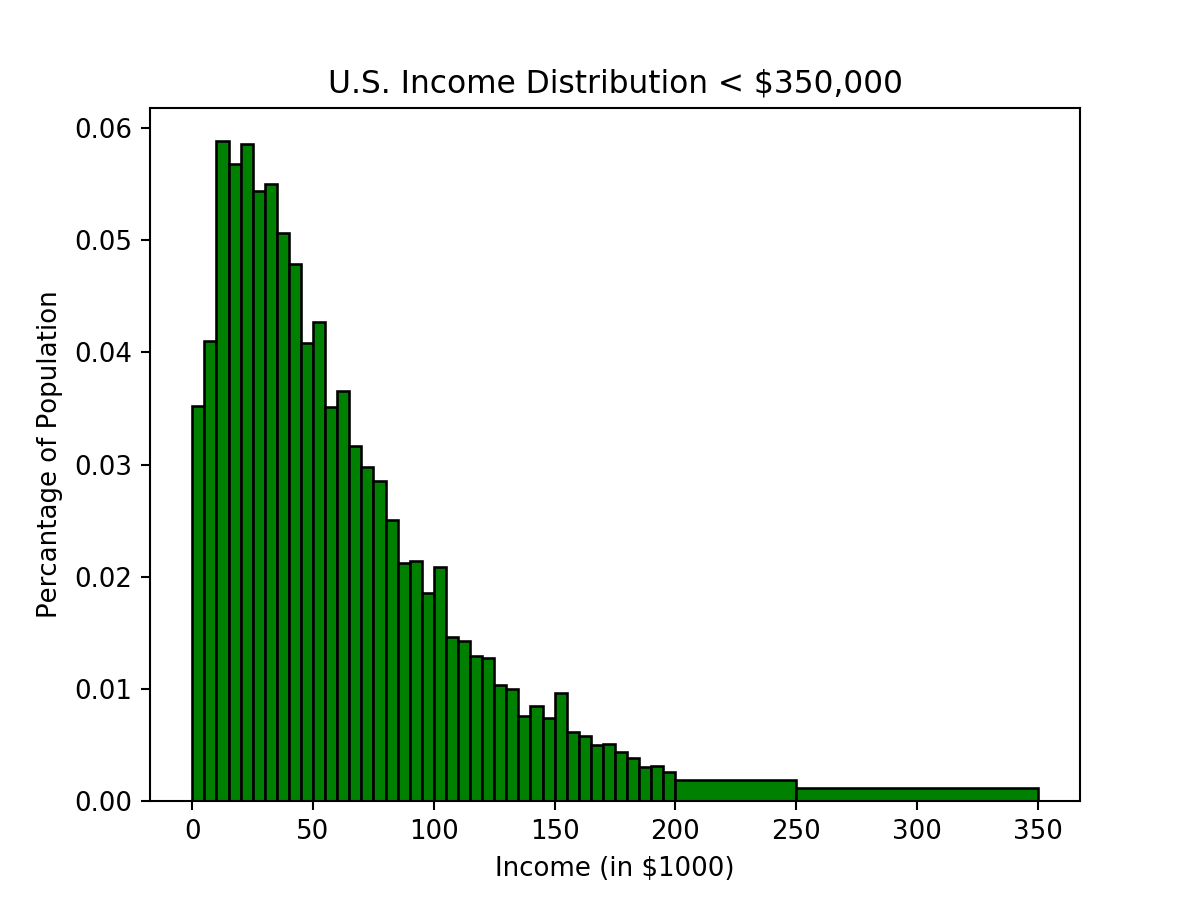

Text(0.5,0,'Income (in $1000)')

In [3]:
# Load U.S. Income Data

incmoms = np.loadtxt('usincmoms.txt')
df = DataFrame(incmoms,columns=['pct','mid'])

# Convert dollar units to thousand dollar units

mid_thou = df.mid.values/1000

# Divide the heights of the last 2 bins (adjust their weights)

weight = df.pct.values
weight[40] = weight[40]/10
weight[41] = weight[41]/20

# Plot histogram for all incomes $350,000 and under

inc_interval = list(range(0,205,5)) + [250,350]
plt.hist(mid_thou,bins=inc_interval,weights=weight,edgecolor = 'k',
        facecolor = 'green')
plt.title('U.S. Income Distribution < $350,000')
plt.ylabel('Percantage of Population')
plt.xlabel('Income (in $1000)')

## (b)

In [4]:
# Define the log-normal pdf

def log_norm_pdf(xvals,mu,sigma):
    pdf_vals = np.exp((-(np.log(xvals) - mu)**2) / (2 * sigma**2)) \
    / (xvals * sigma * np.sqrt(2 * np.pi))

    return pdf_vals

# Define model moments for the log-normal

def moms_mod_LN(mu,sigma):
    model_moment = np.ones(42)
    for i in range(40):
        model_moment[i] = sts.lognorm.cdf(5*(i+1),sigma,scale = np.exp(mu)) \
                        - sts.lognorm.cdf(5*i,sigma,scale = np.exp(mu))
    model_moment[40] = sts.lognorm.cdf(250,sigma,scale = np.exp(mu)) \
                    - sts.lognorm.cdf(200,sigma,scale = np.exp(mu))
    model_moment[41] = sts.lognorm.cdf(350,sigma,scale = np.exp(mu)) \
                    - sts.lognorm.cdf(250,sigma,scale = np.exp(mu))
    return model_moment

# Define data moments 

moms_data = weight

# Define weighting matrix W

W = np.diag(moms_data)

# Define error vector

def err_vec_LN(mu,sigma):
    err_vec = moms_mod_LN(mu,sigma) - moms_data
    
    return err_vec

# Define criterion function

def criterion_LN(params,*args):
    mu, sigma = params
    W = args
    error = err_vec_LN(mu,sigma)
    crit_vals = error.T @ W @ error
    
    return crit_vals

In [6]:
# Implement GMM Estimation - Log Normal

mu_0     = np.log(mid_thou.mean())
sigma_0  = np.log(mid_thou.std())
params_0 = np.array([mu_0,sigma_0])
gmm_bound= np.array([(None,None),(1e-10,None)])
gmm_args = W

results_LN  = opt.minimize(criterion_LN,params_0,args=gmm_args,
                       method = 'L-BFGS-B',bounds = gmm_bound)
mu_gmm, sig_gmm = results_LN.x
err_gmm_LN = err_vec_LN(mu_gmm,sig_gmm)
val_min_crit_LN = err_gmm_LN.T @ W @ err_gmm_LN
print('Log Normal GMM Mu = ',mu_gmm)
print('Log Normal GMM Sigma = ',sig_gmm)
print('Value of Minimized Criterion Function = ',val_min_crit_LN)

Log Normal GMM Mu =  3.97481999333
Log Normal GMM Sigma =  1.04410887943
Value of Minimized Criterion Function =  3.27544388865e-05


<IPython.core.display.Javascript object>


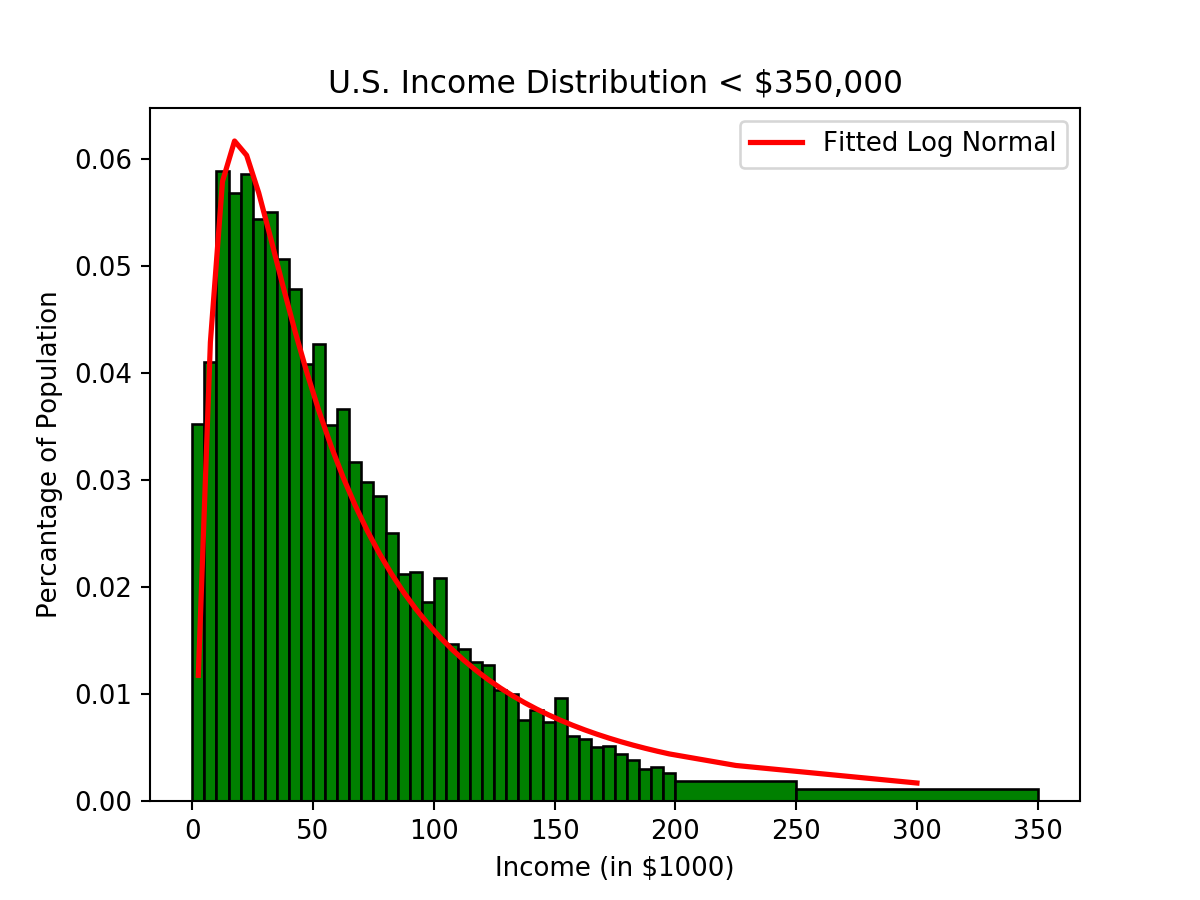

In [8]:
# Plot histogram 

inc_interval = list(range(0,205,5)) + [250,350]
plt.hist(mid_thou,bins=inc_interval,weights=weight,edgecolor = 'k',
        facecolor = 'green')
gmm_mod_moms_LN = moms_mod_LN(mu_gmm,sig_gmm)
gmm_mod_moms_LN[40] = gmm_mod_moms_LN[40]/10
gmm_mod_moms_LN[41] = gmm_mod_moms_LN[41]/20
plt.plot(mid_thou,gmm_mod_moms_LN,linewidth= 2, color = 'r', 
         label= 'Fitted Log Normal')
plt.title('U.S. Income Distribution < $350,000')
plt.ylabel('Percantage of Population')
plt.xlabel('Income (in $1000)')
plt.legend(loc='upper right')

## (c)

In [9]:
# Define the log-normal pdf

def gamma_pdf(xvals,alpha,beta):
    pdf_vals = (1/((beta**alpha) * spec.gamma(alpha))) \
    * (xvals**(alpha-1)) * np.exp(-(xvals/beta))

    return pdf_vals

# Define model moments for the log-normal

def moms_mod_GA(alpha,beta):
    model_moment = np.ones(42)
    for i in range(40):
        model_moment[i] = sts.gamma.cdf(5*(i+1),alpha,scale = beta) \
                        - sts.gamma.cdf(5*i,alpha,scale = beta)
    model_moment[40] = sts.gamma.cdf(250,alpha,scale = beta) \
                    - sts.gamma.cdf(200,alpha,scale = beta)
    model_moment[41] = sts.gamma.cdf(350,alpha,scale = beta) \
                    - sts.gamma.cdf(250,alpha,scale = beta)
    return model_moment

# Define data moments 

moms_data = weight

# Define weighting matrix W

W = np.diag(moms_data)

# Define error vector

def err_vec_GA(alpha,beta):
    err_vec = moms_mod_GA(alpha,beta) - moms_data
    
    return err_vec

# Define criterion function

def criterion_GA(params,*args):
    alpha, beta = params
    W = args
    error_ga = err_vec_GA(alpha,beta)
    crit_vals = error_ga.T @ W @ error_ga
    
    return crit_vals

In [10]:
# Implement GMM Estimation - GAMMA

alpha_0  = 3
beta_0   = 20
params_0 = np.array([alpha_0,beta_0])
gmm_bound= np.array([(1e-10,None),(1e-10,None)])
gmm_args = W

results_GA  = opt.minimize(criterion_GA,params_0,args=gmm_args,
                       method = 'L-BFGS-B',bounds = gmm_bound)
alpha_gmm, beta_gmm = results_GA.x
err_gmm_GA = err_vec_GA(alpha_gmm, beta_gmm)
val_min_crit_GA = err_gmm_GA.T @ W @ err_gmm_GA
print('Gamma GMM alpha = ',alpha_gmm)
print('Gamma GMM beta  = ',beta_gmm)
print('Value of Minimized Criterion Function = ',val_min_crit_GA)

Gamma GMM alpha =  1.43548992657
Gamma GMM beta  =  44.1948758236
Value of Minimized Criterion Function =  6.63025929362e-06


<IPython.core.display.Javascript object>


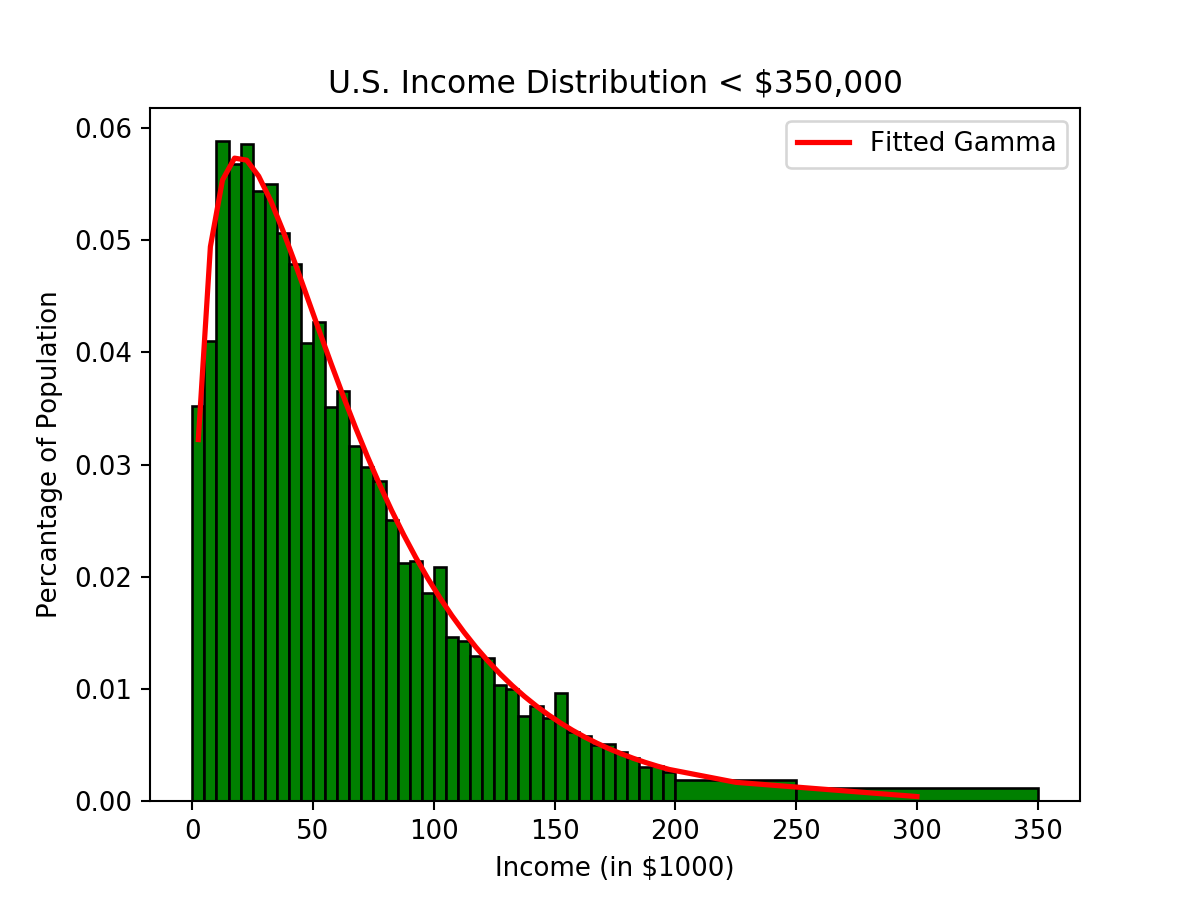

In [11]:
# Plot histogram

inc_interval = list(range(0,205,5)) + [250,350]
plt.hist(mid_thou,bins=inc_interval,weights=weight,edgecolor = 'k',
        facecolor = 'green')
gmm_mod_moms_GA = moms_mod_GA(alpha_gmm,beta_gmm)
gmm_mod_moms_GA[40] = gmm_mod_moms_GA[40]/10
gmm_mod_moms_GA[41] = gmm_mod_moms_GA[41]/20
plt.plot(mid_thou,gmm_mod_moms_GA,linewidth= 2, color = 'r', 
         label= 'Fitted Gamma')
plt.title('U.S. Income Distribution < $350,000')
plt.ylabel('Percantage of Population')
plt.xlabel('Income (in $1000)')
plt.legend(loc='upper right')

## (d)

<IPython.core.display.Javascript object>


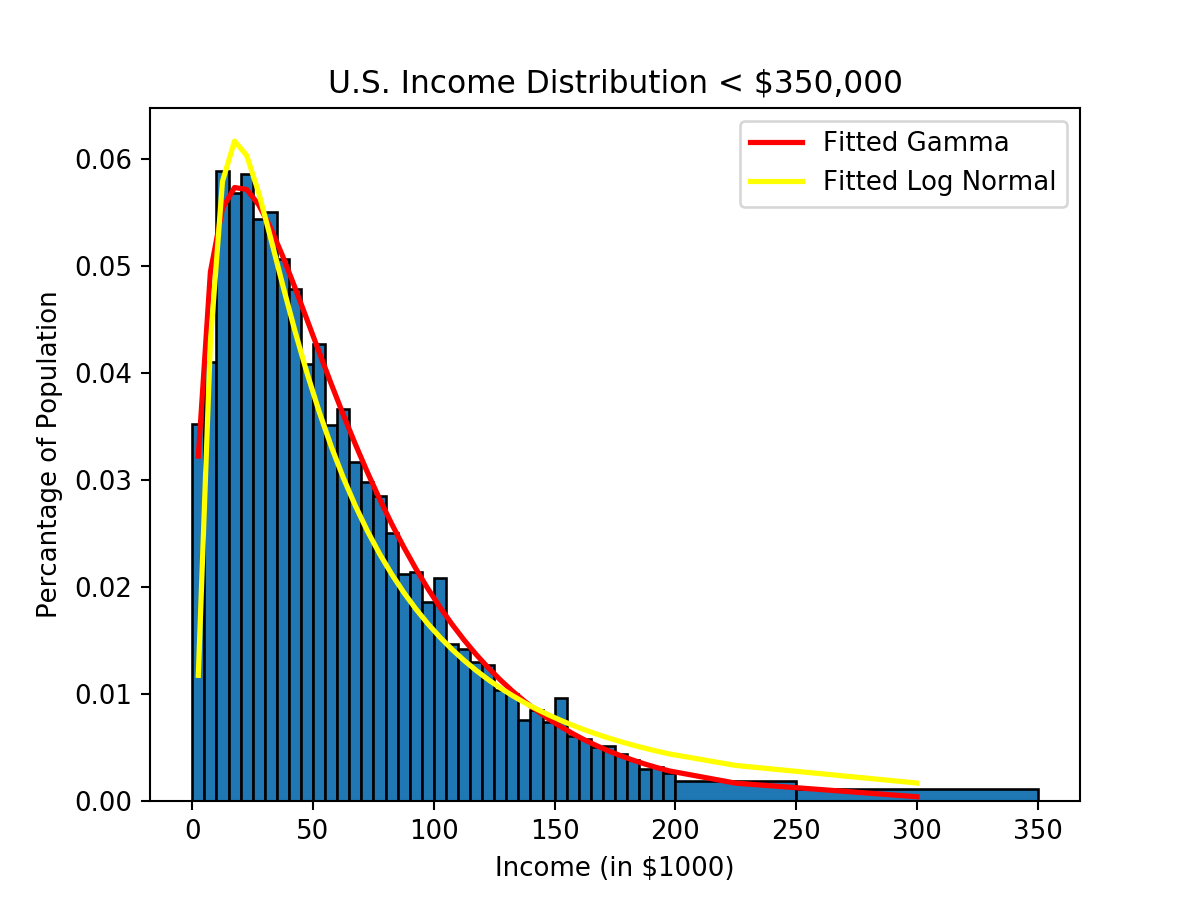

In [14]:
inc_interval = list(range(0,205,5)) + [250,350]
plt.hist(mid_thou,bins=inc_interval,weights=weight,edgecolor = 'k')
plt.plot(mid_thou,gmm_mod_moms_GA,linewidth= 2, color = 'red', 
         label= 'Fitted Gamma')
plt.plot(mid_thou,gmm_mod_moms_LN,linewidth= 2, color = 'yellow', 
         label= 'Fitted Log Normal')
plt.title('U.S. Income Distribution < $350,000')
plt.ylabel('Percantage of Population')
plt.xlabel('Income (in $1000)')
plt.legend(loc='upper right')


In [15]:
print('Log-Normal Value of Minimized Criterion Function = ',val_min_crit_LN)
print('Gamma Value of Minimized Criterion Function = ',val_min_crit_GA)

Log-Normal Value of Minimized Criterion Function =  3.27544388865e-05
Gamma Value of Minimized Criterion Function =  6.63025929362e-06


In the context of our problem that implements Generalized Method of Moments estimation, perhaps the most obvious way to compare the two fitted distributions is to look at the value that minimizes the criterion function. That the minimized value derived under the fitted Gamma distribution is smaller may suggests that the Gamma distribution fits the data better than does the Log-Normal. <br>
<br>
Another way to make comparison would be to look at the fitted distributions overlayed with the histogram of data. Here again, we may conclude that the Gamma distribution better fits the data.

## Problem 2
Estimating the Brock and Mirman (1972) model by GMM
<br>
\begin{align}
& (c_t)^{-1} - \beta E[r_{t+1}(c_{t+1})^{-1}]  & = 0 & \qquad (1)\\
& c_t + k_{t+1} - w_t -r_tk_t  & = 0 & \qquad (2)\\
& w_t-(1-\alpha)e^{z_t}(k_t)^\alpha  & = 0 & \qquad (3)\\
& r_t - \alpha e^{z_t}(k_t)^{\alpha-1} & = 0 & \qquad (4)\\
& \rho z_{t-1} + (1-\rho)\mu +\epsilon_t & = z_t  & \qquad (5) \\
& \qquad \quad \quad \text{   where  } E[\epsilon_t] = 0 \\
\end{align}
<br>
Estimate $(\alpha,\beta,\rho,\mu)$ by GMM under the following constraints:


\begin{align}
& \alpha,\beta \in (0,1), & \mu,\sigma > 0, & \quad \rho \in (-1,1)
\end{align}

Use the unconditional moment conditions that $E[\epsilon_t] = 0$ and $E[\beta r_{t+1} c_t/c_{t+1}-1]=0$

In [26]:
# Load Data

macro_data = pd.read_csv('MacroSeries.txt',sep=',',header=None,names = ['c','k','w','r'])

In [27]:
# Use Equation (4)

def get_z(k,r,alpha):
    z = np.log(r) - np.log(alpha) - (alpha-1)*np.log(k)
    return z

# Use Equation (6)

def eqn_6(z, z_t1, rho, mu):  
    return z_t1-(rho*z + (1-rho)*mu)

# Use Equation (7)

def eqn_7(z, z_t1, rho, mu): 
    return (z_t1-(rho*z + (1-rho)*mu))*z

# Use Equation (8)

def eqn_8(z_t1,k_t1,c,c_t1,alpha,beta):
    return (beta*alpha*np.exp(z_t1)*(k_t1**(alpha-1))*c/c_t1) -1

# Use Equation (9)

def eqn_9 (z_t1,k_t1,c,c_t1,alpha,beta, w):
    return((beta*alpha*np.exp(z_t1)*(k_t1**(alpha-1))*c/c_t1) -1)*w

In [28]:
# Define Weighting Matrix

M = np.eye(4)

# Define Error Vector

def err_vec_BM(c,k,w,r,alpha,beta,rho,mu):
    z = get_z(k,r,alpha)
    z_t1 = z.shift(-1)
    r_t1 = r.shift(-1)
    c_t1 = c.shift(-1)
    k_t1 = k.shift(-1)
    r_t1 = r.shift(-1)
    err_6 = np.mean(eqn_6(z, z_t1, rho, mu))
    err_7 = np.mean(eqn_7(z, z_t1, rho, mu))
    err_8 = np.mean(eqn_8(z_t1,k_t1,c,c_t1,alpha,beta))
    err_9 = np.mean(eqn_9 (z_t1,k_t1,c,c_t1,alpha,beta, w))
    err_vec = np.array([err_6,err_7,err_8,err_9])
    
    return err_vec

# Define Criterion Function

def criterion_BM(params,*args):
    alpha, rho, mu = params
    c,k,w,r,M = args
    err_BM = err_vec_BM(c,k,w,r,alpha,beta,rho,mu)
    
    return err_BM.T @ M @ err_BM

In [29]:
# Implement GMM Estimation

alpha_0  = 0.5
beta     = 0.99
rho_0    = 0.512
mu_0     = 1
params_0 = np.array([alpha_0,rho_0,mu_0])
gmm_args = (macro_data['c'],macro_data['k'],macro_data['w'],macro_data['r'],M)
gmm_bound= np.array([(1e-10,1-1e-10),(1e-10-1,1-1e-10),(1e-10,None)])
results_BM = opt.minimize(criterion_BM,params_0,args=gmm_args,
                         method = 'L-BFGS-B', bounds=gmm_bound)
alpha_gmm_BM, rho_gmm_BM, mu_gmm_BM = results_BM.x
err_gmm_BM = err_vec_BM(macro_data['c'],macro_data['k'],macro_data['w'],macro_data['r'],alpha_gmm_BM,beta,rho_gmm_BM,mu_gmm_BM)
val_min_crit_BM = err_gmm_BM.T @ M @ err_gmm_BM


print('GMM alpha = ',alpha_gmm_BM)
print('GMM rho = ',rho_gmm_BM)
print('GMM mu  = ',mu_gmm_BM)
print('Value of Minimized Criterion Function = ',val_min_crit_BM)

GMM alpha =  0.491584662767
GMM rho =  0.501839440929
GMM mu  =  8.75952074207
Value of Minimized Criterion Function =  1.24566383035e-07
